# What is Cross-validation?
In cross-validation, we run our modeling process on different subsets of the data to get multiple measures of model
quality.

For example, we could begin by dividing the data into 5 pieces, each 20% of the full dataset. In this case, we say that
we have broken the data into 5 "folds".

Then, we run one experiment for each fold:

    1.  In Experiment 1, we use the first fold as a validation (or holdout) set and everything else as training data. This
    gives us a measure of model quality based on a 20% holdout set.

    2.  In Experiment 2, we hold out data from the second fold (and use everything except the second fold for training the
    model). The holdout set is then used to get a second estimate of model quality.

    3.  We repeat this process, using every fold once as the holdout set. Putting this together, 100% of the data is used as
    holdout at some point, and we end up with a measure of model quality that is based on all of the rows in the dataset
    (even if we don't use all rows simultaneously).

# When should we use Cross-validation?
Cross-validation gives a more accurate measure of model quality, which is especially important if you are making a lot
of modeling decisions. However, it can take longer to run, because it estimates multiple models (one for each fold).

Given these tradeoffs, when should we use the Cross-validation?

    1.  For small datasets, where extra computational burden isn't a big deal, you should run cross-validation.
    2.  For larger datasets, a single validation set is sufficient. Your code will run faster, and you may have enough
    data, thus there's little need to re-use some of it to holdout.

There is no simple threshold for what we call small or large dataset. But if your model takes a couple minutes or less
to run, it's probably worth switching to cross-validation.

Alternatively, you can run cross-validation and see if the scores for each experiment seem close. If each experiment
yields similar results, a single validation set it probably sufficient.

we define a pipeline that uses an imputer to fill in missing values and a random forest model to make predictions.

While it's possible to do cross-validation without pipelines, it is quite difficult! Using a pipeline will make the
code remarkably straightforward.

In [57]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from pandas.api.types import is_numeric_dtype
from sklearn.compose import ColumnTransformer

In [58]:
data = pd.read_csv('data/Melbourne_housing_FULL.csv')

In [59]:
data.dropna(axis=0, subset=['Price'], inplace=True)

In [60]:
X_full = data.drop(columns=['Price'], axis=1, inplace=False)

In [61]:
numerical_columns = [col for col in X_full.columns if is_numeric_dtype(X_full[col])]
categorical_data = [col for col in X_full.columns if not is_numeric_dtype(X_full[col])]
low_cardinality_columns = [col for col in X_full[categorical_data].columns if X_full[col].nunique() <= 15]
feature_columns = numerical_columns + low_cardinality_columns

In [62]:
X = X_full[feature_columns]
y = data['Price']
my_model = RandomForestRegressor(n_estimators=100, random_state=11)

In [63]:
numerical_transformer = SimpleImputer(strategy='constant')

Remember, imputer is used also with the categorical data!

In [64]:
categorical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'))
    ]
)

In [65]:
preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', numerical_transformer, numerical_columns),
        ('categorical', categorical_transformer, low_cardinality_columns)
    ]
)



In [66]:
my_pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('model', my_model)
    ]
)

In [67]:
scores = (-1) * cross_val_score(
    estimator=my_pipeline,
    X=X,
    y=y,
    cv=5,
    scoring='neg_mean_absolute_error'
)

In [68]:
print('Mean Absolute Error scores for 5 cross-validations:\n', scores)

Mean Absolute Error scores for 5 cross-validations:
 [227326.65577777 186191.33448151 159232.2382077  167166.26433012
 163272.05000634]


In [69]:
avg_mae = scores.mean()
print('Average Mean Absolute Error score across 5 cross-validations:\n', avg_mae)

Average Mean Absolute Error score across 5 cross-validations:
 180637.7085606867


In [70]:
min_mae = scores.min()
print('Minimum Mean Absolute Error score across 5 cross-validations:\n', min_mae)

Minimum Mean Absolute Error score across 5 cross-validations:
 159232.238207698


In [71]:
def get_score(n_estimators):

    pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('model', RandomForestRegressor(n_estimators=n_estimators, random_state=11))
    ])

    nmae_scores = (-1) * cross_val_score(
        estimator=pipeline,
        X=X,
        y=y,
        cv=5,
        scoring='neg_mean_absolute_error'
    )

    return nmae_scores.mean()

In [72]:
different_n_estimators = [i for i in range(50, 401, 50)]
scores_for_n_estimators = dict()

In [73]:
for n_estimators in different_n_estimators:
    scores_for_n_estimators[n_estimators] = get_score(n_estimators)

In [74]:
print(scores_for_n_estimators)

{50: 181464.3368395975, 100: 180637.7085606867, 150: 180343.20882696073, 200: 180235.63432694203, 250: 179942.51481215618, 300: 179819.3634718268, 350: 179695.06084327225, 400: 179688.63764178238}


In [76]:
best_n_estimators = min(scores_for_n_estimators, key=scores_for_n_estimators.get)

In [77]:
print(f'Best Mean Absolute Error: {scores_for_n_estimators[best_n_estimators]}\n'
      f'was obtained using {best_n_estimators}')

Best Mean Absolute Error: 179688.63764178238
was obtained using 400


In [78]:
import matplotlib
from matplotlib import pyplot as plt

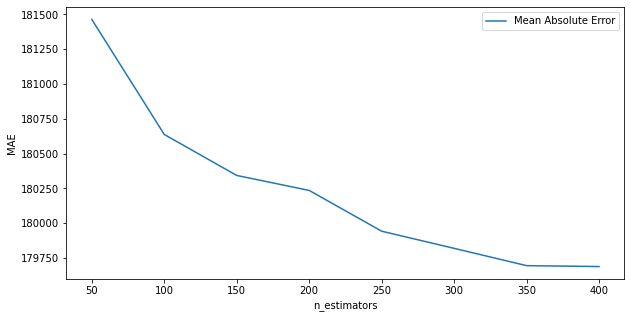

In [80]:
plt.figure(figsize=(10, 5))
plt.plot(
    scores_for_n_estimators.keys(),
    scores_for_n_estimators.values(),
    label='Mean Absolute Error'
)
plt.xlabel('n_estimators'), plt.ylabel('MAE')
plt.legend()
plt.show()